In [146]:
import numpy as np 
import matplotlib.pyplot as plt
import time
import seaborn as sns
import random
from gymnasium import Env, spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [147]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [148]:
def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
            
    return points

class Agent:
    def __init__(self, field_height, field_width, pos=None):
        self.field_height = field_height
        self.field_width = field_width
        self.action_space = spaces.Discrete(9)  # 8 moves + shoot
        self.pos = pos
        self.position = np.array(pos) if pos is not None else np.array([
            np.random.randint(0, field_height),
            np.random.randint(0, field_width)
        ])
        self.shoot_speed = 5
        self.shoot_speed_decay = 1

    def policy(self, state, epsilon):
        # Epsilon-greedy policy
        if np.random.uniform(0, 1) < epsilon:
            return self.action_space.sample()
        else:
            q_values = self.q_table[state, :]
            return np.argmax(q_values)

    def reset_position(self):
        if self.pos is None:
            self.position = np.array([
                np.random.randint(0, self.field_height),
                np.random.randint(0, self.field_width)
            ])
        return self.position

    def shoot_ball(self, current_position, goal_position):
        # Convert positions to integers for Bresenham algorithm
        start_x, start_y = int(current_position[0]), int(current_position[1])
        target_x, target_y = int(goal_position[0]), int(goal_position[1])
        
        # Calculate trajectory points using Bresenham's algorithm
        trajectory_points = bresenham_line(start_x, start_y, target_x, target_y)
        
        # Skip the first point (current position)
        if len(trajectory_points) > 1:
            trajectory_points = trajectory_points[1:]
        
        # Calculate direction vector (normalized)
        direction = np.array([goal_position[0] - current_position[0], 
                             goal_position[1] - current_position[1]])
        direction_norm = np.linalg.norm(direction)
        
        if direction_norm > 0:
            direction = direction / direction_norm
        else:
            direction = np.array([0, 0])
        
        return trajectory_points, self.shoot_speed, direction
    

class FootballEnv(Env):
    def __init__(self, field_height, field_width, agent):
        super(FootballEnv, self).__init__()

        self.field_height = field_height  # x-axis (rows)
        self.field_width = field_width  # y-axis (columns)
        self.goal_y = self.field_width - 1  # Goal at the far right (y-axis)

        # Observation Space: Combination of agent position and ball position
        # This creates a unique state for each possible combination
        self.observation_space = spaces.Discrete(field_height * field_width * field_height * field_width)

        self.field = np.full((self.field_height, self.field_width), '.', dtype=str)
        self.rewards = np.full((self.field_height, self.field_width), -1, dtype=np.float32)
        
        # Goal area has a higher reward
        self.rewards[:, self.goal_y] = 10.0  

        self.ball_holder = 0
        self.agent = agent
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0

        # Initialize Q-table with the expanded state space
        self.agent.q_table = np.zeros((self.observation_space.n, agent.action_space.n))

        self.reset()

    def reset(self, seed=None, options=None):
        self.agent.reset_position()
        self.ball_pos = np.array([np.random.randint(0, self.field_height), np.random.randint(0, self.field_width)])
        self.ball_holder = 0
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.done = False

        if np.array_equal(self.agent.position, self.ball_pos):
            self.ball_holder = 1
            self.ball_pos = self.agent.position.copy()
            self.ball_in_transit = False

        return self._get_state_index()

    def _get_state_index(self):
        # Create a unique state index that combines agent position and ball position
        agent_pos_index = self.agent.position[0] * self.field_width + self.agent.position[1]
        ball_pos_index = self.ball_pos[0] * self.field_width + self.ball_pos[1]
        
        # Combine them into a single state index
        state_index = agent_pos_index * (self.field_height * self.field_width) + ball_pos_index
        return state_index
        
    def closest_goal_cell(self, agent_pos):
        # select one cell from the goal area
        goal_cells = [(i, self.goal_y) for i in range(self.field_height)]
        # return the closest goal cell to the agent
        closest_cell = min(goal_cells, key=lambda cell: np.linalg.norm(np.array(agent_pos) - np.array(cell)))
        return closest_cell
        
    def step(self, action):
        reward = 0  # Initialize rewards
        
        # Define movement mapping for 8 directions
        move_map = {
            0: np.array([0, 1]),   # Right
            1: np.array([1, 1]),   # Down-Right
            2: np.array([1, 0]),   # Down
            3: np.array([1, -1]),  # Down-Left
            4: np.array([0, -1]),  # Left
            5: np.array([-1, -1]), # Up-Left
            6: np.array([-1, 0]),  # Up
            7: np.array([-1, 1])   # Up-Right
        }

        # Get the action for the agent
        if action in move_map:
            move = move_map[action]
            new_position = self.agent.position + move

            # Check if the new position is within bounds
            if (0 <= new_position[0] < self.field_height) and (0 <= new_position[1] < self.field_width):
                self.agent.position = new_position
                
                # If agent had the ball, the ball moves with the agent
                if self.ball_holder == 1:
                    self.ball_pos = self.agent.position.copy()
                
                # Check if the agent just got the ball
                elif self.ball_holder == 0 and np.array_equal(self.agent.position, self.ball_pos):
                    self.ball_holder = 1
                    self.ball_pos = self.agent.position.copy()
                    # Reward for picking up the ball
                    reward += 50
        
        elif action == 8:  # Shoot
            # Check if the agent is holding the ball
            if self.ball_holder == 1:
                closest_shot = self.closest_goal_cell(self.agent.position)
                # Calculate the trajectory of the ball
                self.ball_trajectory, self.ball_transit_speed, self.ball_transit_direction = self.agent.shoot_ball(self.agent.position, closest_shot)
                self.ball_in_transit = True
                self.ball_holder = 0  # Ball is no longer held by the agent
                self.ball_trajectory_index = 0  # Reset trajectory index
        
        # Handle ball movement if in transit
        if self.ball_in_transit:
            # First apply speed decay at the beginning of the step
            if self.ball_transit_speed <= 0:
                self.ball_in_transit = False
                self.ball_transit_speed = 0
            else:
                self.ball_transit_speed -= self.agent.shoot_speed_decay
                
            # If ball is still in transit after speed decay
            if self.ball_in_transit:
                # Calculate how many steps to move based on current speed
                steps_to_move = max(1, int(round(self.ball_transit_speed)))
                
                # Move the ball along its trajectory by the number of steps determined by speed
                for _ in range(steps_to_move):
                    if self.ball_trajectory_index < len(self.ball_trajectory):
                        # Get the next position from the trajectory
                        next_pos = self.ball_trajectory[self.ball_trajectory_index]
                        self.ball_pos = np.array(next_pos)
                        self.ball_trajectory_index += 1
                        
                        # Check if ball reached the goal
                        if self.ball_pos[1] == self.goal_y:
                            # Add goal reward (1000) + field reward (10) = 1010
                            goal_reward = 1000
                            field_reward = self.rewards[self.ball_pos[0], self.ball_pos[1]]
                            total_reward = goal_reward + field_reward
                            reward += total_reward
                            self.ball_holder = 0  # Ball is no longer held by the agent
                            self.done = True  # End the episode on goal
                            self.ball_in_transit = False
                            break
                    else:
                        # Ball has completed its trajectory
                        self.ball_in_transit = False
                        self.ball_transit_speed = 0
                        break
                        
                # Check if any agent is at the ball's position after movement
                if not self.ball_in_transit and np.array_equal(self.agent.position, self.ball_pos):
                    self.ball_holder = 1  # Agent reclaims the ball
                    reward += 20  # Additional reward for reclaiming the ball after shooting
        
        # Calculate distance-based reward to encourage moving toward the ball
        if self.ball_holder == 0 and not self.ball_in_transit:
            # Calculate distance to ball
            distance_to_ball = np.linalg.norm(self.agent.position - self.ball_pos)
            # Small reward for being closer to the ball
            proximity_reward = -0.1 * distance_to_ball
            reward += proximity_reward
            
        # Only add field reward if we haven't already scored a goal (to avoid double counting)
        if not self.done:
            # Get the current state reward from the rewards matrix
            state_reward = self.rewards[self.agent.position[0], self.agent.position[1]]
            reward += state_reward
        
        # Return the new state, reward, and done flag
        return self._get_state_index(), reward, self.done, {}
    
    def train(self, num_episodes, max_steps=200, epsilon_start=1.0, epsilon_decay=0.995, min_epsilon=0.01, gamma=0.99, learning_rate=0.1):
        state = self.reset()
        episode_rewards = []
        epsilon = epsilon_start  # Start with a high exploration rate
        
        for episode in range(num_episodes):
            state = self.reset()
            done = False
            total_reward = 0
            steps = 0
            
            while not done and steps < max_steps:
                # Choose action using epsilon-greedy policy
                action = self.agent.policy(state, epsilon)
                
                # Take a step in the environment
                next_state, reward, done, _ = self.step(action)
                total_reward += reward
                
                # Q-learning update
                best_next_action = np.argmax(self.agent.q_table[next_state])
                td_target = reward + gamma * self.agent.q_table[next_state, best_next_action] * (not done)
                td_error = td_target - self.agent.q_table[state, action]
                self.agent.q_table[state, action] += learning_rate * td_error
                
                state = next_state
                steps += 1
                
            # Decay epsilon after each episode
            epsilon = max(min_epsilon, epsilon * epsilon_decay)
            
            # Print progress
            if (episode + 1) % 10 == 0:
                print(f"Episode {episode + 1}/{num_episodes}, Steps: {steps}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.4f}")
                if self.ball_holder == 1:
                    print("Episode ended with agent holding the ball")
                
            episode_rewards.append(total_reward)
            
        return episode_rewards

    def render(self):
        field_copy = np.full((self.field_height, self.field_width), '.', dtype=str)
        
        # First, place the ball (if it's not held by an agent)
        if self.ball_holder == 0:
            field_copy[self.ball_pos[0], self.ball_pos[1]] = 'B'  # (x, y) indexing
        
        # render 'A' for agent
        field_copy[self.agent.position[0], self.agent.position[1]] = 'A'
        
        # If agent has the ball, show it as 'A+B'
        if self.ball_holder == 1:
            field_copy[self.agent.position[0], self.agent.position[1]] = '@'
            
        # render 'G' for goal area
        field_copy[:, self.goal_y] = 'G'
                
        # If ball is in transit, show trajectory
        if self.ball_in_transit:
            for idx, (x, y) in enumerate(self.ball_trajectory):
                if idx >= self.ball_trajectory_index:  # Only show remaining trajectory
                    if 0 <= x < self.field_height and 0 <= y < self.field_width:
                        if field_copy[x, y] == '.':  # Don't overwrite agents
                            field_copy[x, y] = '*'

        print("\n".join(["".join(row) for row in field_copy]) + "\n")
        print(f"Ball holder: {'Agent' if self.ball_holder == 1 else 'None'}")
        print(f"Agent position: {self.agent.position}")
        print(f"Ball position: {self.ball_pos}")


# # Example usage
# if __name__ == "__main__":
#     field_height = 7
#     field_width = 10
#     agent = Agent(field_height, field_width)
#     env = FootballEnv(field_height, field_width, agent)
    
#     # Train the agent
#     rewards = env.train(num_episodes=1000, max_steps=100, epsilon_start=1.0, epsilon_decay=0.995)
    
#     # Test the trained agent
#     print("\nTesting trained agent:")
#     state = env.reset()
#     done = False
#     total_reward = 0
#     steps = 0
    
#     while not done and steps < 50:
#         env.render()
#         action = agent.policy(state, epsilon=0)  # Use greedy policy (no exploration)
#         state, reward, done, _ = env.step(action)
#         total_reward += reward
#         steps += 1
        
#     print(f"Test completed with total reward: {total_reward}")

Initial State:
......B...G
.....A....G
..........G
..........G
..........G

Ball holder: None
Agent position: [1 5]
Ball position: [0 6]
Episode 10/100000, Steps: 200, Total Reward: 1323.86, Epsilon: 0.3487
Episode 20/100000, Steps: 200, Total Reward: 1710.91, Epsilon: 0.1216
Episode 30/100000, Steps: 200, Total Reward: 1703.17, Epsilon: 0.1000
Episode 40/100000, Steps: 200, Total Reward: 1754.62, Epsilon: 0.1000
Episode 50/100000, Steps: 200, Total Reward: 1841.83, Epsilon: 0.1000
Episode 60/100000, Steps: 66, Total Reward: 1701.56, Epsilon: 0.1000
Episode ended with agent holding the ball
Episode 70/100000, Steps: 13, Total Reward: 1087.40, Epsilon: 0.1000
Episode ended with agent holding the ball
Episode 80/100000, Steps: 151, Total Reward: 2490.76, Epsilon: 0.1000
Episode ended with agent holding the ball
Episode 90/100000, Steps: 200, Total Reward: 1445.53, Epsilon: 0.1000
Episode 100/100000, Steps: 200, Total Reward: 1617.92, Epsilon: 0.1000
Episode 110/100000, Steps: 7, Total Re

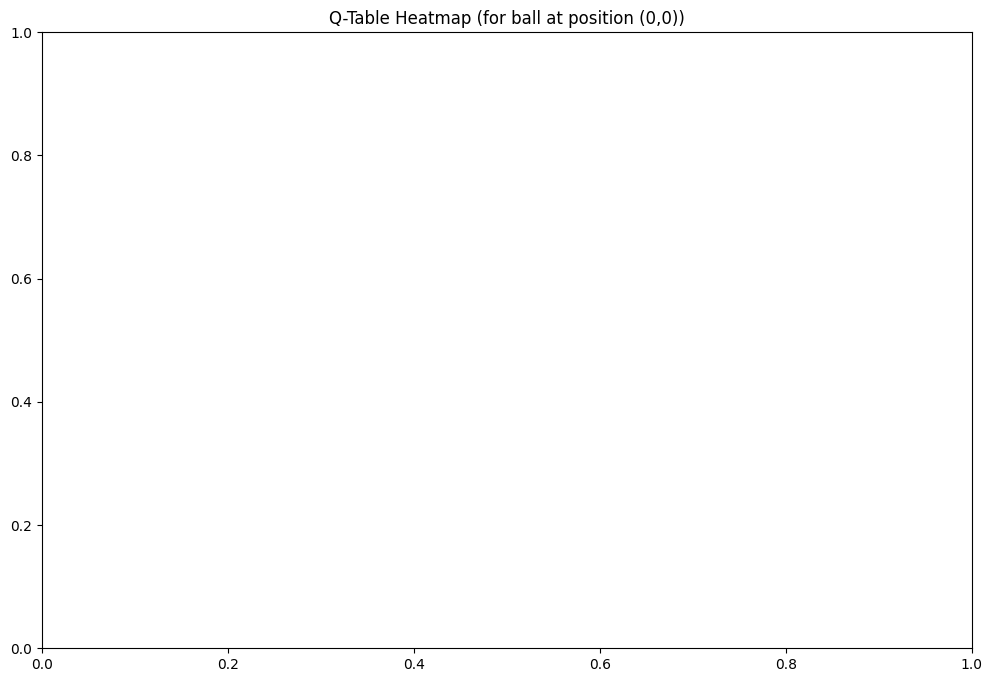

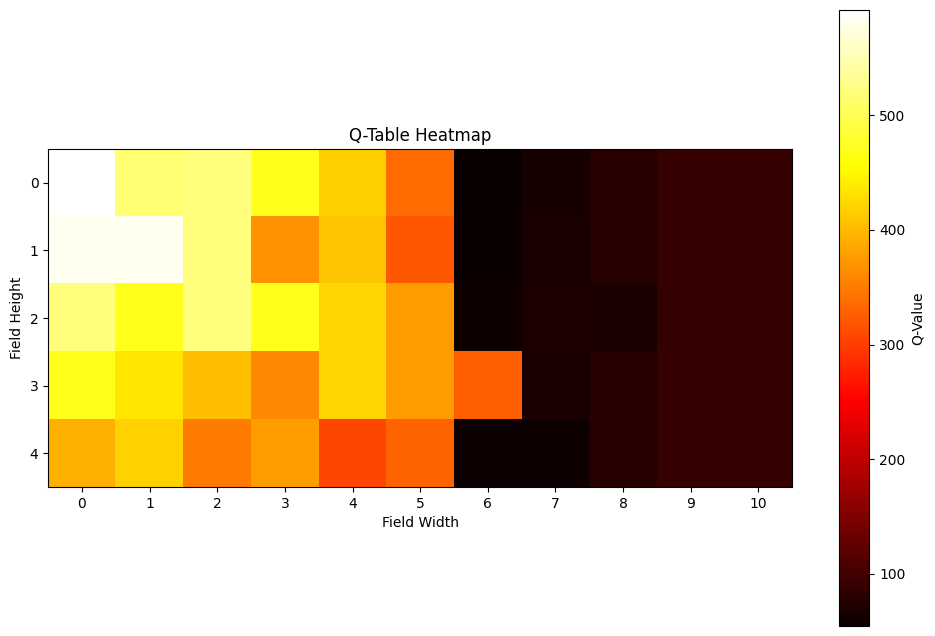

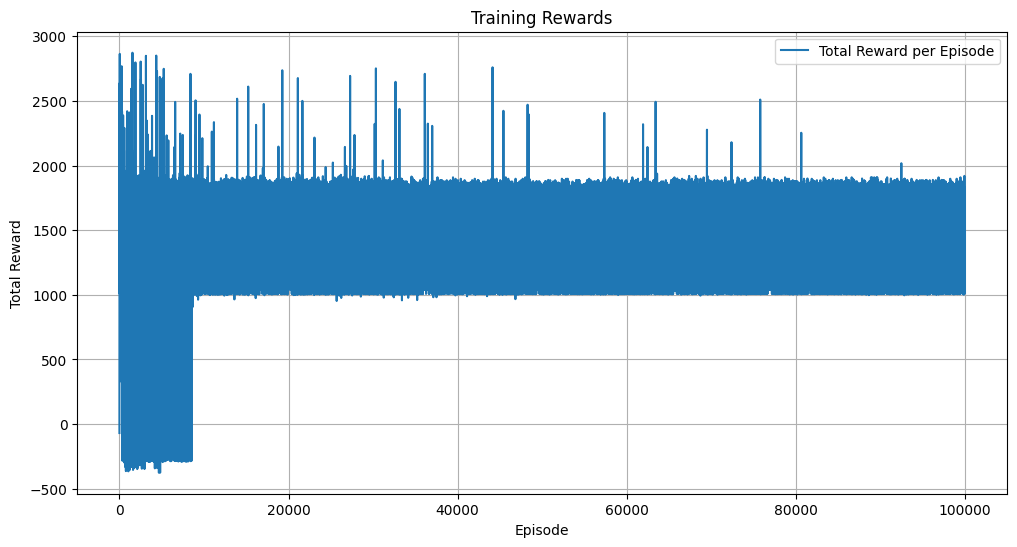

In [ ]:
# Initialize the environment
field_height = 5
field_width = 11
agent = Agent(field_height, field_width)  # Start in the middle of the field
env = FootballEnv(field_height, field_width, agent)

# Dry run for a few steps
state = env.reset()
print("Initial State:")
env.render()

rewards = env.train(num_episodes=100000, max_steps=200 ,epsilon_decay=0.9, min_epsilon=0.1, gamma=0.9, learning_rate=0.1)

# reshape and plot q table
ball_pos_fixed = (0, 0)
ball_state_index = ball_pos_fixed[0] * field_width + ball_pos_fixed[1]

# Extract Q-values for the specific ball position
q_values_subset = []
for agent_x in range(field_height):
    for agent_y in range(field_width):
        agent_pos_index = agent_x * field_width + agent_y
        state_index = agent_pos_index * (field_height * field_width) + ball_state_index
        q_values_subset.append(agent.q_table[state_index])

# Reshape for visualization based on agent positions only
q_table_subset = np.array(q_values_subset).reshape(field_height, field_width, agent.action_space.n)

# Now plot this subset
plt.figure(figsize=(12, 8))
plt.title("Q-Table Heatmap")
plt.imshow(np.max(q_table_subset, axis=2), cmap='hot', interpolation='nearest')
plt.colorbar(label='Q-Value')
plt.xlabel('Field Width')
plt.ylabel('Field Height')
plt.xticks(np.arange(field_width), np.arange(field_width))
plt.yticks(np.arange(field_height), np.arange(field_height))
plt.grid(False)
plt.show()

# Plot the rewards over episodes
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Rewards')
plt.legend()
plt.grid()
plt.show()

In [152]:
def evaluate(env, num_episodes=5, max_steps=100):
    """
    Evaluate the trained agent across multiple episodes.
    
    Args:
        env: The football environment
        num_episodes: Number of episodes to evaluate
        max_steps: Maximum steps per episode
        
    Returns:
        List of rewards per episode
    """
    episode_rewards = []
    
    for episode in range(num_episodes):
        # Reset environment
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        
        print(f"\nEvaluation Episode {episode + 1}/{num_episodes}")
        print("Initial state:")
        env.render()
        
        while not done and steps < max_steps:
            # Use the policy with epsilon=0 (no exploration, pure exploitation)
            action = env.agent.policy(state, epsilon=0)
            
            # Take step in environment
            next_state, reward, done, _ = env.step(action)
            
            # Update for next iteration
            state = next_state
            total_reward += reward
            steps += 1
            
            # Print step info
            print(f"\nStep {steps}, Action: {action}, Reward: {reward:.2f}")
            env.render()
            
            # Optional: add a small delay to make visualization easier to follow
            import time
            time.sleep(0.5)  # 0.5 second delay
        
        print(f"Episode {episode + 1} finished after {steps} steps with reward: {total_reward:.2f}")
        
        # Check if goal was scored
        if done:
            print("Goal scored!")
        else:
            print("Max steps reached without scoring.")
            
        episode_rewards.append(total_reward)
    
    # Print summary
    print("\nEvaluation Summary:")
    print(f"Average reward over {num_episodes} episodes: {sum(episode_rewards)/len(episode_rewards):.2f}")
    print(f"Episodes with goals: {sum(1 for r in episode_rewards if r > 100)}/{num_episodes}")
    
    return episode_rewards

# Example usage:
    # Assuming you've already trained the agent
evaluate(env, num_episodes=3, max_steps=50)


Evaluation Episode 1/3
Initial state:
..B.......G
..........G
..........G
..A.......G
..........G

Ball holder: None
Agent position: [3 2]
Ball position: [0 2]

Step 1, Action: 7, Reward: -1.22
..B.......G
..........G
...A......G
..........G
..........G

Ball holder: None
Agent position: [2 3]
Ball position: [0 2]

Step 2, Action: 5, Reward: -1.10
..B.......G
..A.......G
..........G
..........G
..........G

Ball holder: None
Agent position: [1 2]
Ball position: [0 2]

Step 3, Action: 5, Reward: -1.10
.AB.......G
..........G
..........G
..........G
..........G

Ball holder: None
Agent position: [0 1]
Ball position: [0 2]

Step 4, Action: 0, Reward: 49.00
..@.......G
..........G
..........G
..........G
..........G

Ball holder: Agent
Agent position: [0 2]
Ball position: [0 2]

Step 5, Action: 1, Reward: -1.00
..........G
...@......G
..........G
..........G
..........G

Ball holder: Agent
Agent position: [1 3]
Ball position: [1 3]

Step 6, Action: 1, Reward: -1.00
..........G
..........G

[np.float64(1051.97639320225),
 np.float64(1067.4585786437626),
 np.float64(474.99009804864073)]